# Introduction

The followig aims to get you up and running with the predict. Make a copy of the notebook and run all cells. We will also show you how to get your submission file from kaggle. 

In [93]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [94]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

# Importing the Dataset
- We firstly import the given dataset
- Look at the 5 first rows
- Check for missing values using info

In [95]:
df_sample_submission = pd.read_csv("sample_submission.csv")
df_movies = pd.read_csv('movies.csv')
df_imdb = pd.read_csv('imdb_data.csv')
df_genome_scores = pd.read_csv('genome_scores.csv')
df_genome_tags = pd.read_csv('genome_tags.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_tags = pd.read_csv('tags.csv')
df_links = pd.read_csv('links.csv')

### Data Preprocessing

### Summary Statistics
 Looking at the first few entries in the dataset

We want to find out how the structure of the dataset works and how many records do we have in each of these tables.

# Movie Dataset

In [96]:
df_movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [97]:
df_movies.shape

(62423, 3)

In [98]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


# Obeservation
- movieId: movie name 
- title: title for each movie
- genres: contains more than one genre per movie
The data contains 62423 rows with 3 columns and no null values

In [99]:
df_train.head()

userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539
3  106362    32296     2.0  1423042565
4    9041      366     3.0   833375837

In [100]:
# Shape of the dataset
df_train.shape

(10000038, 4)

In [101]:
df_train.describe()

userId       movieId        rating     timestamp
count  1.000004e+07  1.000004e+07  1.000004e+07  1.000004e+07
mean   8.119909e+04  2.138911e+04  3.533395e+00  1.215677e+09
std    4.679359e+04  3.919578e+04  1.061124e+00  2.268921e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    4.051000e+04  1.197000e+03  3.000000e+00  1.011742e+09
50%    8.091400e+04  2.947000e+03  3.500000e+00  1.199019e+09
75%    1.215790e+05  8.630000e+03  4.000000e+00  1.447242e+09
max    1.625410e+05  2.091710e+05  5.000000e+00  1.574328e+09

In [102]:
df_train.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [103]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


# Train Dataset
- UserId: For users' ID
- MovieId: ID for each movie
- Rating: ratings for each movie
- timestamp: Time and Date representation in seconds
- Train dataset has no null values , it contains 10000038 rows with 4 columns

# IMDB Dataset



In [104]:
df_imdb.head()

movieId                                         title_cast  \
0        1  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...   
1        2  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   
2        3  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...   
3        4  Whitney Houston|Angela Bassett|Loretta Devine|...   
4        5  Steve Martin|Diane Keaton|Martin Short|Kimberl...   

              director  runtime       budget  \
0        John Lasseter     81.0  $30,000,000   
1   Jonathan Hensleigh    104.0  $65,000,000   
2  Mark Steven Johnson    101.0  $25,000,000   
3       Terry McMillan    124.0  $16,000,000   
4       Albert Hackett    106.0  $30,000,000   

                                       plot_keywords  
0                   toy|rivalry|cowboy|cgi animation  
1                   board game|adventurer|fight|game  
2                         boat|lake|neighbor|rivalry  
3  black american|husband wife relationship|betra...  
4                    fatherhood|doberman|dog|mansion

In [105]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


In [106]:
df_imdb.isnull().sum()

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64

# Observation
- movieId: An unique ID for each movie
- title_cast: names of actors in a movie
- director: director of a movie
- plot_keywords: describes plots of a mvoie
- budget: amount of money used to produce a movie
- runtime: duration of the movie
- The dataset  has null values , and contains 6 columns with 27278 rows 

# Checking for missing values on the Dataset

In [13]:
df_test.isnull().sum()

userId     0
movieId    0
dtype: int64

Test has no missing values

In [14]:
df_tags.isnull().sum()

userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

Tags has 16 missings values on tags and no null values  on the other 3 columns

In [15]:
df_genome_scores.isnull().sum()

movieId      0
tagId        0
relevance    0
dtype: int64

genome scores has no missing values

In [16]:
df_genome_tags.isnull().sum()

tagId    0
tag      0
dtype: int64

genome tags has no missing values

In [17]:
df_imdb.isnull().sum()

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64

imdb has no nulls on movieId and missing values on title_cast, director, runtime, budget, and plot_keywords

In [21]:
df_movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

movies has no null values

In [63]:
df_links.isnull().sum()

movieId      0
imdbId       0
tmdbId     107
dtype: int64

 links has missing values in tmdId 

# Analysis of imdb dataset

In [107]:
dataset =pd.merge(df_train, df_movies, on= ('movieId'))
dataset.tail()

userId  movieId  rating   timestamp  \
10000033   84146   107912     3.0  1389449965   
10000034   72315   190143     2.5  1567628158   
10000035  131116   206347     3.0  1568558126   
10000036   85757   196867     3.5  1563175258   
10000037   72315    97148     3.0  1567584197   

                                            title               genres  
10000033                       Fallen, The (2004)     Action|Drama|War  
10000034                          Formentera Lady   (no genres listed)  
10000035                          Nocturne (1946)  Crime|Drama|Mystery  
10000036                      Guys & Balls (2004)       Comedy|Romance  
10000037  Elia Kazan: A Director's Journey (1995)          Documentary

Changing timestamp into proper date time

In [108]:
import datetime
from datetime import datetime, date
dataset['datetime'] = pd.to_datetime(dataset['timestamp'])

In [109]:
dataset.shape

(10000038, 7)

Checking for unique data

In [110]:
dataset.nunique()

userId        162541
movieId        48213
rating            10
timestamp    8795101
title          48151
genres          1558
datetime     8795101
dtype: int64

In [111]:
dataset.describe()

userId       movieId        rating     timestamp
count  1.000004e+07  1.000004e+07  1.000004e+07  1.000004e+07
mean   8.119909e+04  2.138911e+04  3.533395e+00  1.215677e+09
std    4.679359e+04  3.919578e+04  1.061124e+00  2.268921e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    4.051000e+04  1.197000e+03  3.000000e+00  1.011742e+09
50%    8.091400e+04  2.947000e+03  3.500000e+00  1.199019e+09
75%    1.215790e+05  8.630000e+03  4.000000e+00  1.447242e+09
max    1.625410e+05  2.091710e+05  5.000000e+00  1.574328e+09

Avarage rating for each movie

In [112]:
#Avarage_rating
data1=dataset
data1=data1.groupby('title')['rating'].mean()
data1

title
"BLOW THE NIGHT!" Let's Spend the Night Together (1983)    3.000000
"Great Performances" Cats (1998)                           2.753731
#1 Cheerleader Camp (2010)                                 1.900000
#Female Pleasure (2018)                                    4.000000
#FollowMe (2019)                                           2.400000
                                                             ...   
به نام پدر                                                 3.250000
…And the Fifth Horseman Is Fear (1965)                     3.000000
チェブラーシカ (2010)                                             2.000000
貞子3D (2012)                                                2.562500
줄탁동시 (2012)                                                3.000000
Name: rating, Length: 48151, dtype: float64

In [113]:
sorted_ratings_wise_movies=data1.sort_values(ascending=False)

Total number of ratings for a particular movie

In [114]:
movie_ranking=dataset.groupby('title')['rating'].count()
movie_ranking.tail()

title
به نام پدر                                2
…And the Fifth Horseman Is Fear (1965)    1
チェブラーシカ (2010)                            3
貞子3D (2012)                               8
줄탁동시 (2012)                               1
Name: rating, dtype: int64

In [115]:
#Making a new Dataframe
new_record = pd.DataFrame()
new_record ['Average_ratings']=data1

In [116]:
new_record['Count of total ratings'] = movie_ranking
new_record.head()

Average_ratings  \
title                                                                 
"BLOW THE NIGHT!" Let's Spend the Night Togethe...         3.000000   
"Great Performances" Cats (1998)                           2.753731   
#1 Cheerleader Camp (2010)                                 1.900000   
#Female Pleasure (2018)                                    4.000000   
#FollowMe (2019)                                           2.400000   

                                                    Count of total ratings  
title                                                                       
"BLOW THE NIGHT!" Let's Spend the Night Togethe...                       1  
"Great Performances" Cats (1998)                                        67  
#1 Cheerleader Camp (2010)                                               5  
#Female Pleasure (2018)                                                  1  
#FollowMe (2019)                                                         5

In [117]:
#Importing data visualisation libraries
import seaborn as sns

sns.set_style('white')


<Figure size 720x144 with 0 Axes>

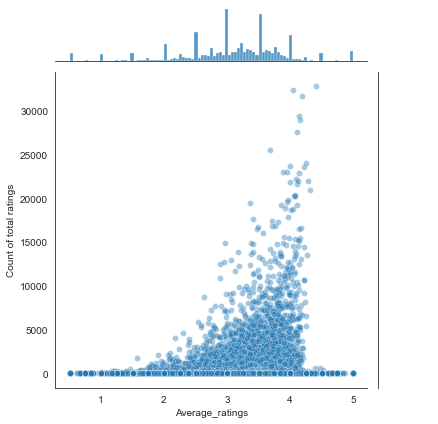

The first line sets a style of the graph. Then we have the coordinates in the arrays x and y. 

In [42]:
df_sample_submission.head()

Id  rating
0  1_2011     1.0
1  1_4144     1.0
2  1_5767     1.0
3  1_6711     1.0
4  1_7318     1.0


# Exploratory Data Analysis

We need to perform investigative and detective analysis on our data to see if we can gain any useful insights. We have data being generated from movie recommendation, it’s important to utilize Exploratory Data Analysis to analyze all this data, with the aid of Visuals to help organizations make data-driven decisions.

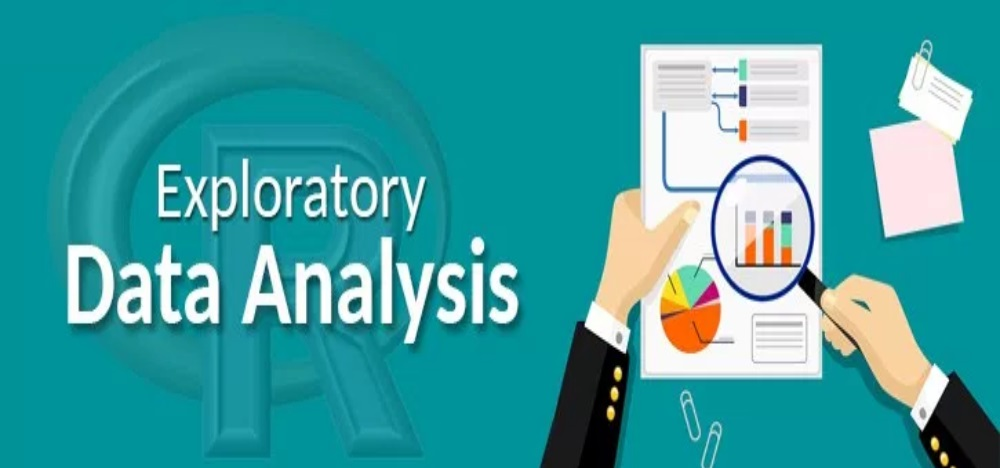

**Most common Genres**

We will firstly observe the frequency of genres since from our observation above genre has multiple genres seperated by | hence we firstly have to split the genres 

In [66]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|')) 


# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

movieId     genres
0        1  Adventure
1        1  Animation
2        1   Children
3        1     Comedy
4        1    Fantasy

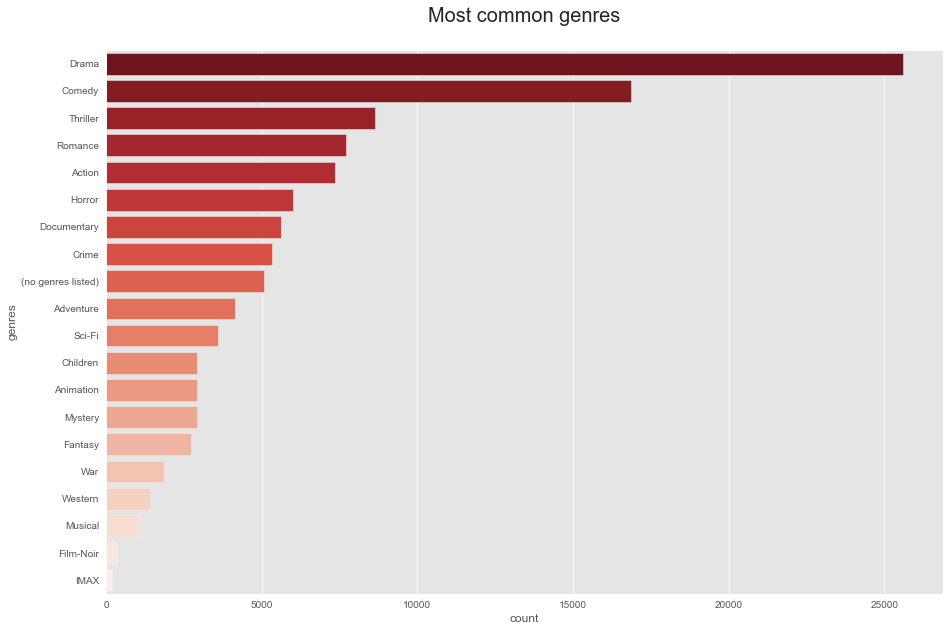

In [44]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

A word cloud is a technique used in visualization to represent text data in such a way that the size of each word in the text indicate its significance or occurrences. Words that are largely displayed have a high frequency in the text.



In [129]:
import wordcloud
all_words = ''.join([label for label in df_movies['genres']])

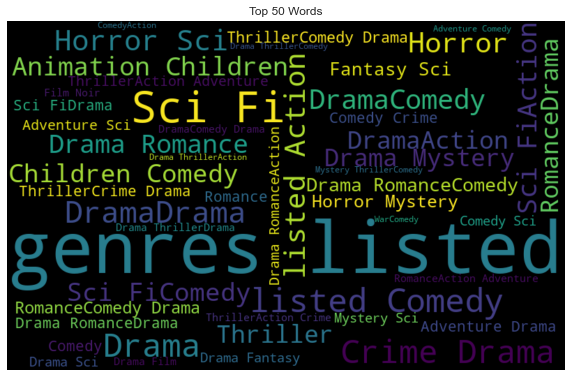

In [132]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Words')

plt.show()

Drama appears to be the most popular genre followed by Comedy

In [62]:
genreList= []
for index, row in movies_genres.iterrows():
    genres =row['genres']
    
    for genre in genres:
        if genre not in genreList:
         genreList.append(genre)
genreList[:10] #list for unique genres

['A', 'd', 'v', 'e', 'n', 't', 'u', 'r', 'i', 'm']

# Analysing the Movies dataset

Average Rating for Movies

In [45]:
#Avarage_rating
data1=dataset
data1=data1.groupby('title')['rating'].mean()
data1

title
"BLOW THE NIGHT!" Let's Spend the Night Together (1983)    3.000000
"Great Performances" Cats (1998)                           2.753731
#1 Cheerleader Camp (2010)                                 1.900000
#Female Pleasure (2018)                                    4.000000
#FollowMe (2019)                                           2.400000
                                                             ...   
به نام پدر                                                 3.250000
…And the Fifth Horseman Is Fear (1965)                     3.000000
チェブラーシカ (2010)                                             2.000000
貞子3D (2012)                                                2.562500
줄탁동시 (2012)                                                3.000000
Name: rating, Length: 48151, dtype: float64

In [46]:
sorted_ratings_wise_movies=data1.sort_values(ascending=False)

In [47]:
movie_ranking=dataset.groupby('title')['rating'].count()
movie_ranking.tail()

title
به نام پدر                                2
…And the Fifth Horseman Is Fear (1965)    1
チェブラーシカ (2010)                            3
貞子3D (2012)                               8
줄탁동시 (2012)                               1
Name: rating, dtype: int64

In [48]:
#Making a new Dataframe
new_record = pd.DataFrame()
new_record ['Average_ratings']=data1

<AxesSubplot:>

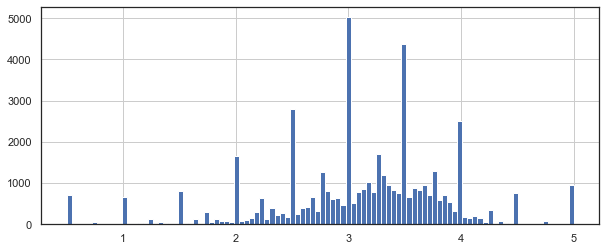

In [125]:
#Plotting the graph of 'ratings' column
plt.figure(figsize = (10,4))

new_record['Average_ratings'].hist(bins =100)

<Figure size 720x144 with 0 Axes>

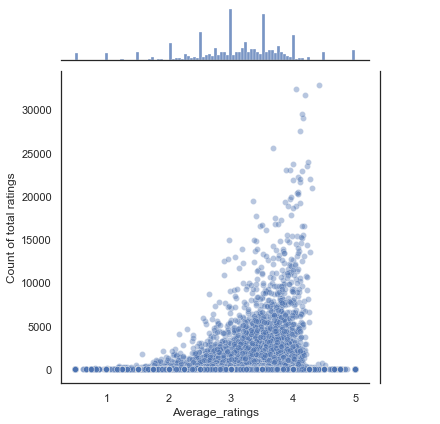

In [126]:
plt.figure(figsize=(10,2))
sns.jointplot(x ='Average_ratings', y='Count of total ratings', data=new_record, alpha=0.4)

In [134]:
fig = go.Figure()

fig.add_trace(go.Indicator(
    mode = "number",
    value = df_movies['movieId'].count(),
    domain = {'row': 0, 'column': 0}, 
    title = 'Total Movies'))

fig.add_trace(go.Indicator(
    mode = "number",
    value = df_train['userId'].nunique(),
    domain = {'row': 1, 'column': 0}, 
    title = 'Total Users'))


fig.add_trace(go.Indicator(
    mode = "number",
    value = df_train['rating'].mean(),
    domain = {'row': 0, 'column': 1}, 
    title = 'Average Rating for Movies'))

fig.add_trace(go.Indicator(
    mode = "number",
    value = df_imdb['runtime'].mean(skipna = True),
    domain = {'row': 1, 'column': 1}, 
    title = 'Average Runtime for Movies'))

fig.update_layout(
    grid = {'rows': 2, 'columns': 2, 'pattern': "independent"}, 
    template = 'plotly_dark')

# Distribution of the number of ratings per user

In [90]:
user_p = df_train.groupby('userId')['rating'].count().clip(upper=50)
fig = go.Figure()

fig.add_trace(go.Histogram(x = user_p.values,
                     name = 'rating',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 1)))

fig.update_layout(
    title = {
        'text': 'Number of Ratings Per User (First 50)',
        'font': {
            'size': 25
        }
    },
    title_x = 0.5,
    template = 'plotly_white',
    bargap = 0.2
)

fig.update_xaxes(
    title = {
        'text': 'Ratings Per User'
    }
)

fig.update_yaxes(
    title = {
        'text': 'Count'
    }
)

fig.update_traces(marker_color = 'red')

Based on the distribution above, it seems that there are users with next to nothing ratings. This is an indication that these users could not contribute to recommending movies.

# Distribution of ratings

In [121]:
ratings= df_train['rating'].value_counts().sort_index()

In [122]:
rating_df= pd.DataFrame(columns= ['total', 'rating'])
rating_df['rating']= list(ratings.index)
rating_df['total'] = ratings.values

In [123]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x = rating_df['rating'],
    y = rating_df['total'],
    text = ['{:.1f} %'.format((val / rating_df['total'].sum() * 100)) for val in (rating_df['total'])],
    textposition = 'auto',
    textfont = dict(color = '#FFFFFF')
))

fig.update_layout(
    title = {
        'text': 'Rating Distribution',
        'font': {
            'size': 25
        }
    },
    title_x = 0.5,
    template = 'plotly_white'
)

fig.update_xaxes(
    title = {
        'text': 'Ratings'
    }
)

fig.update_yaxes(
    title = {
        'text': 'Count Per Rating'
    }
)

fig.update_traces(marker_color = 'red')

The distribution shows a skewedness in the positive direction and Majority of the ratings is around 3 and 4 which is a good rating 

# Distribution of the number of ratings per movie

In [124]:
movie_p = df_train.groupby('movieId')['rating'].count().clip(upper=50)
fig = go.Figure()

fig.add_trace(go.Histogram(x = movie_p.values,
                     name = 'movieId',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 1)))

fig.update_layout(
    title = {
        'text': 'Number of Ratings Per Movie (First 50)',
        'font': {
            'size': 25
        }
    },
    title_x = 0.5,
    template = 'plotly_white',
    bargap = 0.2
)

fig.update_xaxes(
    title = {
        'text': 'Ratings Per Movie'
    }
)

fig.update_yaxes(
    title = {
        'text': 'Count'
    }
)

fig.update_traces(marker_color = 'red')

Observing from the graph above there are movies with low number of rating, these ratings can not contribute to the recommendations because , if only one user rated a specific movie , their preference does not explain preference of other multiple users'. 

In [83]:
new_record['Count of total ratings'] = movie_ranking
new_record.head()

Average_ratings  \
title                                                                 
"BLOW THE NIGHT!" Let's Spend the Night Togethe...         3.000000   
"Great Performances" Cats (1998)                           2.753731   
#1 Cheerleader Camp (2010)                                 1.900000   
#Female Pleasure (2018)                                    4.000000   
#FollowMe (2019)                                           2.400000   

                                                    Count of total ratings  
title                                                                       
"BLOW THE NIGHT!" Let's Spend the Night Togethe...                       1  
"Great Performances" Cats (1998)                                        67  
#1 Cheerleader Camp (2010)                                               5  
#Female Pleasure (2018)                                                  1  
#FollowMe (2019)                                                         5

The bar graph shows that the best movies are those with the highest number of tatings as they are rated by most viewers.

# Working with Director colomn

In [66]:
# Create dataframe containing only the movieId and director name
imdb_director = pd.DataFrame(df_imdb[['movieId', 'title_cast', 'director' ]],
                             columns=['movieId', 'title_cast', 'director' ])


imdb_director.head()

movieId                                         title_cast  \
0        1  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...   
1        2  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   
2        3  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...   
3        4  Whitney Houston|Angela Bassett|Loretta Devine|...   
4        5  Steve Martin|Diane Keaton|Martin Short|Kimberl...   

              director  
0        John Lasseter  
1   Jonathan Hensleigh  
2  Mark Steven Johnson  
3       Terry McMillan  
4       Albert Hackett

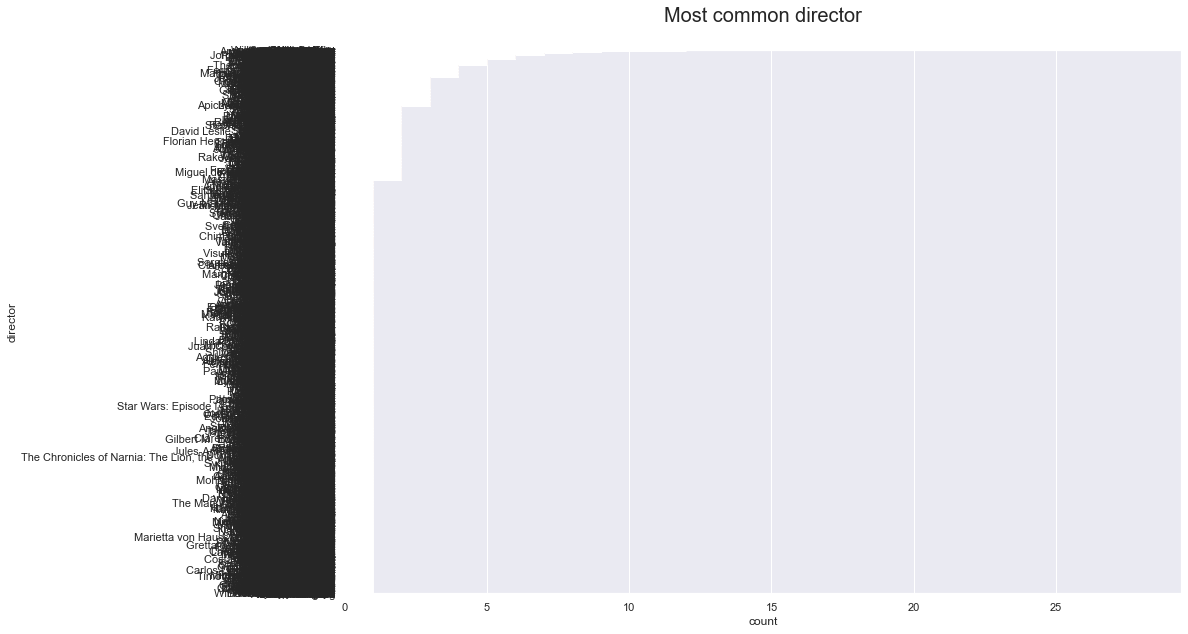

In [68]:
# Plot the director from most common to least common
plot = plt.figure(figsize=(12, 10))
plt.title('Director with highest movies', fontsize=30)
sns.countplot(y="director", data=imdb_director,
              order=imdb_director['director'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()


In [133]:

fig = go.Figure()

fig.add_trace(go.Indicator(
    mode = "number",
    value = df_imdb['director'].count(),
    domain = {'row': 0, 'column': 0}, 
    title = 'Total Movies'))

fig.add_trace(go.Indicator(
    mode = "number",
    value = df_movies['movieId'].nunique(),
    domain = {'row': 1, 'column': 0}, 
    title = 'Total movie title'))


fig.add_trace(go.Indicator(
    mode = "number",
    value = df_train['rating'].mean(),
    domain = {'row': 0, 'column': 1}, 
    title = 'Average Rating for Movies'))

fig.add_trace(go.Indicator(
    mode = "number",
    value = df_imdb['runtime'].mean(skipna = True),
    domain = {'row': 1, 'column': 1}, 
    title = 'Average Runtime for Movies'))

fig.update_layout(
    grid = {'rows': 2, 'columns': 2, 'pattern': "independent"}, 
    template = 'plotly_dark')

In [ ]:
plt.subplots

## Data Prepartion

In [8]:
## Here you will sort your data out and process it accordingly

## Modelling phase

Here you can apply the models outline in the Intro to Recommender Notebook. You only need to apply one version 
be it Content based or Collabrative method



In [9]:
# Apply your modelling here

# Generate your outputs here

Prepare Submission File
We make submissions in CSV files. Your submissions usually have two columns: an ID column and a prediction column. The ID field comes from the test data (keeping whatever name the ID field had in that data, which for the data is the string 'Id'). The prediction column will use the name of the target field.

We will create a DataFrame with this data, and then use the dataframe's to_csv method to write our submission file. Explicitly include the argument index=False to prevent pandas from adding another column in our csv file.

In [10]:
# This is an example
## my_submission = pd.DataFrame({'id': test.Id, 'rating': test.ratings})
# you could use any filename. We choose submission here
## my_submission.to_csv('submission.csv', index=False)


### Make Submission
Hit the blue Publish button at the top of your notebook screen. It will take some time for your kernel to run. When it has finished your navigation bar at the top of the screen will have a tab for Output. This only shows up if you have written an output file (like we did in the Prepare Submission File step).

Example below of how the output would look once published

In [11]:
# initialize list of lists
data = [['tom', 10], ['nick', 15], ['juli', 14]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['Name', 'Age'])
  
# print dataframe.
df

Name  Age
0   tom   10
1  nick   15
2  juli   14

In [12]:
df.to_csv('my_test_output.csv', index = False)